# Budget allocation proposal

### Pseudo-Revenue, First-Revenue assumption
### Regressions

In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from ipynb.fs.defs.nb3 import scatterRevenues, KFold, plotSummedRevenues, scatterErrorSummedRevenues, getOverallError, plotFinalResults

%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

validDf = pd.read_csv("../data/valid_dataset_minimal.csv").drop(columns=["Unnamed: 0"])
campaigns = validDf["Campaign"].unique()
validDf["Date"] = pd.to_datetime(validDf["Date"])
# print(validDf.head(10))
print(validDf.dtypes)

Date                     datetime64[ns]
Source / Medium                  object
Campaign                         object
Device Category                  object
Users                             int64
Sessions                          int64
Bounces                           int64
Transactions                      int64
Cost                            float64
Revenue                         float64
Product Detail Views              int64
Product Adds To Cart              int64
Product Checkouts                 int64
Session Duration                 object
Total Unique Searches             int64
Pageviews                        object
New Users                         int64
Session Duration (s)            float64
Medium                           object
dtype: object


## 0. Dataset creation

### 0.1 Bucketing

In [2]:
def getCampaignFirstRevenue(df):
    df["Bucket Index"] = 0
    # This holds the indexes (starting from 0) in the df where we've got positive revenues
    indexesR = df.loc[df["Revenue"] > 0, "Revenue"].index.values
    # The same, but shifted to the left with one value and starting with -1
    indexesL = np.array([-1, *indexesR[0 : -1]])
    nRows = len(indexesL)

    bucketIndex = -1
    for i in range(nRows):
        l, r = indexesL[i], indexesR[i]
        where = (df.index > l) & (df.index <= r)
        items = df[where]
        # This merges conseccutive buckets if some of them have sum of costs 0, as that'd be useless data
        # Instead, we assume that multiple consecutive revenues must be merged together and divided to first
        if items["Cost"].sum() > 0:
            bucketIndex += 1
        df.loc[where, "Bucket Index"] = bucketIndex
    
    items = df[df.index > indexesR[-1]]
    assert len(items) == 0
    return df

# Return a new column called "bucket index", which represents on what (Cost, Revenue) bucket each entry goes
# This is unique for all campaigns, so bucket index == 1 for Campaign "A", is a different bucket from bucket
#  index == 1 for Campaign "B". This column is used to train on the same logical data (Bucket, Revenue), and
#  we don't get Costs from same bucket both in train and validation set.
# Other assumptions (like weekly assumption) can update this indexes as they will to provide other logic of
#  implementation for the dataset split.
def getDataFirstRevenue(df):
    newDf = pd.DataFrame(columns=df.columns)
    campaigns = df["Campaign"].unique()
    for campaign in campaigns:
        dfCampaign = df[df["Campaign"] == campaign].reset_index(drop=True)
        newDfCampaign = getCampaignFirstRevenue(dfCampaign)
        numBuckets = len(newDfCampaign["Bucket Index"].unique())
        print("Campaign '%s' has %d (Cost, Revenue) buckets." % (campaign, numBuckets), end="")
        if numBuckets < 20:
            print(" Below 20, skipping.")
            continue

        revenues = newDfCampaign["Revenue"]
        # print(campaign, np.percentile(revenues, [0.1, 1, 10, 25, 50, 75, 90, 99, 99.5, 99.9, 100]))
        # Clip the revenues to top 99.5%, to eliminate outliers.
        Max = newDfCampaign["Revenue"].max()
        Top99_5 = np.percentile(newDfCampaign["Revenue"], 99.9)
        print(" Pruning max revenue from %2.3f to %2.3f" % (Max, Top99_9))
        newDfCampaign["Label Revenue"] = np.clip(newDfCampaign["Revenue"], 0, Top99_5)
        newDf = pd.concat([newDf, newDfCampaign], sort=False)      
    return newDf

firstRevenueDf = getDataFirstRevenue(validDf)
print("___________________________________")
print("Original df: %s. Training df: %s" % (validDf.shape, firstRevenueDf.shape))

Campaign 'AW - Accessories' has 452 (Cost, Revenue) buckets. Pruning max revenue from 1523.180 to 1523.180
Campaign 'AW - Apparel' has 138 (Cost, Revenue) buckets. Pruning max revenue from 1623.750 to 1623.750
Campaign 'Remarketing' has 5 (Cost, Revenue) buckets. Below 20, skipping.
Campaign 'AW - Dynamic Search Ads Whole Site' has 382 (Cost, Revenue) buckets. Pruning max revenue from 2224.430 to 2224.430
Campaign 'AW - Bags' has 52 (Cost, Revenue) buckets. Pruning max revenue from 284.580 to 284.580
Campaign 'AW - Google Brand' has 56 (Cost, Revenue) buckets. Pruning max revenue from 627.490 to 627.490
Campaign 'AW - Office' has 36 (Cost, Revenue) buckets. Pruning max revenue from 1857.000 to 1857.000
Campaign 'AW - YouTube' has 5 (Cost, Revenue) buckets. Below 20, skipping.
Campaign 'AW - Drinkware' has 10 (Cost, Revenue) buckets. Below 20, skipping.
Campaign 'AW - YouTube Brand' has 10 (Cost, Revenue) buckets. Below 20, skipping.
Campaign 'All Products' has 109 (Cost, Revenue) bucke

### 0.2 Pseudo-Revenue

For Linear Regression we've got the problem that the training data and the testing data is not from the same distribution.

Basically, the problem is that we are training on Data: $X=\sum(Costs)$ and Labels: $t=Revenue$, however, when we are using the model, we are generating from the distribution Data: $X=Cost$, PseudoRevenue: $y=f(X)$.

The problem can be the simplest explained as: $a * f(x_1 + x_2) + b \neq [a * f(x_1) + b] + [a * f(x_2) + b] $.

However, we can always pre-split our data in first-revenue assumption AND linear time assumption (see proposal), basically instead of having $X=\sum_n(Costs)$, $t=Revenue$, we can have $X=[Cost_1, ..., Cost_n]$, $t=[\frac{Cost_1}{Revenue}, ..., \frac{Cost_n}{Revenue}]$.

The second nuance here is that we've got our data split in buckets of $(Cost, Revenue)$. Thus, what we do instead is for each bucket:

$Cost_{B} = [Cost_1, ..., Cost_n]$ and $Revenue_{B} = [Revenue_1, ..., Revenue_m]$. We sum the revenues and the costs independently, to get $C_{\Sigma B} = \sum_{i}^{n}Cost_i$ and $R_{\Sigma B} = \sum_{i}^{m}Revenue_i$. We get the bucket's constant $\alpha_B = \frac{R_{\Sigma B}}{C_{\Sigma B}}$

For statistical model, we had a dataset constant, which was the model's only parameter. Here, we get a bucket constant, which we use to create the pseudo revenue, by multiplying each cost: $Pseudo-Revenue_{B} = [Cost_1 * \alpha_B, ..., Cost_n * \alpha_B]$

If we were to not use a linear time assumption, we'd have a non-linear ponder $C_{\Sigma B} = \sum_{i}^{n}(Cost_i * w_{i,n})$ where $w_{i, n}$ is somehow dependant on current timestamp (i) and final timestamp until last time of this bucket (n). This can be done using a separate model or some other way of detecting it. However, we'll just use a constant $w=1$ and assume all costs are identical to generating the next revenue.

**Example:**
Let a bucket be: $Cost_B=[0, 0, 50, 20, 0, 15]$, $Revenue_B=[30, 100]$. This means that the first revenue (30) was generated by the first two costs alone, so we merged the next bucket as well.

We'll sum them, getting $C_{\Sigma B}=85$ and $R_{\Sigma B}=130$. Then, the bucket constant is: $\alpha_B=130/85=1.529$.

Then, our pseudo-revenues will be: $Pseudo-Revenue_{B} = [0*\alpha_B, 0*\alpha_B, 50*\alpha_B, 20*\alpha_B, 0*\alpha_B, 15*\alpha_B] = [0, 0, 76.45, 30.58, 0, 22.935]$.

These are the values we'll predict for this bucket in our Regressions. We can see that summing them, we get $129.965$, which is almost $130$, the error being caused by truncations.

In [3]:
def f(x):
    sumCost = x["Cost"].sum()
    sumRevenue = x["Label Revenue"].sum()
    bucketConstant = sumRevenue / sumCost
    return bucketConstant

def getPseudoRevenues(df):
    df = df.copy()
    dfGB = df.groupby(["Campaign", "Bucket Index"]).apply(lambda x : pd.Series({
        "Bucket Constant" : f(x)
    })).reset_index()
    df = pd.merge(df, dfGB, on=["Campaign", "Bucket Index"])
    df["Label Pseudo Revenue"] = df["Cost"] * df["Bucket Constant"]
    return df

trainDf = getPseudoRevenues(firstRevenueDf)
trainDf["Bucket Index"] = trainDf["Bucket Index"].astype(int)

### 0.2 Get Dataset statistics: Mins/Maxs

In [4]:
def getMinMax(df):
    numericDf = df.select_dtypes(include=[np.number])
    numericDf = numericDf.join(df["Campaign"])
    Mins = numericDf.groupby("Campaign").min().reset_index()
    Maxs = numericDf.groupby("Campaign").max().reset_index()
    return Mins, Maxs

Mins, Maxs = getMinMax(trainDf)
display(Mins)
display(Maxs)

,Campaign,Cost,Revenue,Session Duration (s),Bucket Index,Label Revenue,Bucket Constant,Label Pseudo Revenue
0,AW - Accessories,0.01,0.0,0.0,0,0.0,0.037720,0.000532
1,AW - Apparel,0.01,0.0,0.0,0,0.0,0.017278,0.000173
2,AW - Bags,0.01,0.0,0.0,0,0.0,0.069662,0.000697
3,AW - Dynamic Search Ads Whole Site,0.01,0.0,0.0,0,0.0,0.029557,0.003863
4,AW - Google Brand,0.01,0.0,0.0,0,0.0,0.033009,0.000330
5,AW - Office,0.01,0.0,0.0,0,0.0,0.377298,0.003773
6,All Products,0.01,0.0,0.0,0,0.0,0.583503,0.010041


,Campaign,Cost,Revenue,Session Duration (s),Bucket Index,Label Revenue,Bucket Constant,Label Pseudo Revenue
0,AW - Accessories,74.04,1523.18,215881.0,451,1523.18,1721.739130,1187.360787
1,AW - Apparel,45.38,1623.75,215100.0,137,1623.75,2059.000000,429.053154
2,AW - Bags,35.76,284.58,214020.0,51,284.58,112.769231,284.580000
3,AW - Dynamic Search Ads Whole Site,54.57,2224.43,215940.0,381,2224.43,112.391137,2068.540027
4,AW - Google Brand,35.17,627.49,215880.0,55,627.49,134.000000,621.073947
5,AW - Office,17.52,1857.00,215100.0,35,1857.00,2210.714286,1857.000000
6,All Products,9.02,324.20,214080.0,108,324.20,860.500000,226.562713


# 1. Linear Regression (no extra features)

In [5]:
# import torch as tr
# import torch.nn as nn

# tr.backends.cudnn.deterministic = True
# tr.backends.cudnn.benchmark = False

# class LinearRegression(nn.Module):
#     def __init__(self, useBias=True):
#         super(LinearRegression, self).__init__()
#         self.useBias = useBias
#         self.trained = False

#     def prepare(self, X, t):
#         assert self.trained == False
#         assert X.min() >= 0 and X.max() <= 1
#         assert t.min() >= 0 and t.max() <= 1

#         # Add bias
#         if self.useBias:
#             X = np.append(X, np.ones((len(X), 1), dtype=np.float32), axis=-1)

#         self.numFeatures = X.shape[-1]
#         tr.manual_seed(42)
#         self.W = tr.randn(self.numFeatures, 1).requires_grad_(True)

#         X = tr.from_numpy(X.astype(np.float32))
#         t = tr.from_numpy(t.astype(np.float32)).unsqueeze(dim=-1)
#         return X, t

#     def fit(self, X, t):
#         return self.fit_iter(X, t)
#         # TODO - One day I'll figure this crap out.
#         #X, t = self.prepare(X, t)
#         #A = (X * t).mean(dim=0)
#         #B = (X**2).mean(dim=0)
#         #self.W = (A / B).detach().unsqueeze(dim=-1)

#     def fit_iter(self, X, t, numIterations=10, lr=0.001):
#         X, t = self.prepare(X, t)
#         for i in range(numIterations):
#             L = self.criterion(X, t)
#             L.backward()
#             self.W.data -= lr * self.W.grad
#             self.W.grad *= 0
#         self.trained = True

#     def criterion(self, X, t):
#         y = tr.mm(X, self.W)
#         L = (y - t)**2
#         L = L.mean() + self.W.abs().mean()
#         return L

#     def predict(self, X):
#         assert self.trained == True
#         assert X.min() >= 0 and X.max() <= 1
#         X = X.astype(np.float32)
#         if self.useBias:
#             X = np.append(X, np.ones((len(X), 1), dtype=np.float32), axis=-1)
#         X = tr.from_numpy(X)
#         y = tr.mm(X, self.W)
#         return y.detach().numpy()

Define more stuff for model, such as Kfold and errors

In [6]:
def errorL1(y, t, Mins, Maxs):
    # Renormaize to reality
    y = y * (Maxs - Mins) + Mins
    t = t * (Maxs - Mins) + Mins
    return np.abs(y - t).mean()

def trainModelLR(modelType, X, t, Mappings, errorFn, numSplits=5, randomState=42):
    kf = KFold(numSplits=numSplits, randomState=randomState)
    errors = []
    Max = Mappings.max()
    ix = np.arange(Max)
    
    for trainIx, validationIx in kf.split(Max):
        model = modelType()
        trainMap, valMap = ix[trainIx], ix[validationIx]
        whereTrain = np.isin(Mappings, trainMap)
        whereVal = np.isin(Mappings, valMap)
        model.fit(X[whereTrain], t[whereTrain])
        y = model.predict(X[whereVal])
        errors.append(errorFn(y, t[whereVal]))

    # We report the mean error on all K-fold splits for robustness
    meanError = np.mean(errors)
    
    # Then, we retrain on all data, for best test/future predictions
    model = modelType()
    model.fit(X, t)
    return model, meanError

def applyMinMax(df, Mins, Maxs):
    newDf = df.copy()
    for column in df.columns:
        Denom = (Maxs[column].values - Mins[column].values + 1e-5)
        newDf[column] = (df[column].values - Mins[column].values) / Denom
    return newDf

def trainAllCampaignsLR(df, Stats, modelType, features):
    models, errors = {}, {}
    validCampaigns = df["Campaign"].unique()
    Mins, Maxs = Stats
    relevantFeatures = features + ["Label Pseudo Revenue"]
    test = df[relevantFeatures]
    for i, campaign in enumerate(validCampaigns):
        where = df["Campaign"] == campaign
        campaignMins = Mins.loc[Mins["Campaign"] == campaign, relevantFeatures]
        campaignMaxs = Maxs.loc[Maxs["Campaign"] == campaign, relevantFeatures]
        campaignDf = df.loc[where, relevantFeatures]
        campaignDf = applyMinMax(campaignDf, campaignMins, campaignMaxs)
        errorFn = partial(errorL1, Mins=campaignMins["Label Pseudo Revenue"].values, \
                          Maxs=campaignMaxs["Label Pseudo Revenue"].values)

        X = campaignDf[features].values
        t = campaignDf[["Label Pseudo Revenue"]].values
        Mappings = df.loc[where, "Bucket Index"].values

        model, error = trainModelLR(modelType, X, t, Mappings, errorFn)
        models[campaign] = model
        errors[campaign] = error
    return models, errors

### 1.1 Train model on Cost feature only

In [7]:
Stats = getMinMax(trainDf)
from sklearn.linear_model import LinearRegression
models, errors = trainAllCampaignsLR(trainDf, Stats, LinearRegression, features=["Cost"])
display(pd.DataFrame(errors.items(), columns=["Campaign", "Error (L1)"]))

,Campaign,Error (L1)
0,AW - Accessories,38.581974
1,AW - Apparel,6.943314
2,AW - Dynamic Search Ads Whole Site,35.231792
3,AW - Bags,7.289016
4,AW - Google Brand,6.143370
5,AW - Office,10.882698
6,All Products,8.848415


### 1.2 Create Pseudo Revenue column for each column based on best model

In [8]:
def createPseudoRevenues(models, df, Stats, features):
    validCampaigns = models.keys()
    finalDf = pd.DataFrame(columns=df.columns)
    Mins, Maxs = Stats

    relevantFeatures = features + ["Label Pseudo Revenue"]
    for i, campaign in enumerate(validCampaigns):
        where = df["Campaign"] == campaign
        campaignMins = Mins.loc[Mins["Campaign"] == campaign, relevantFeatures]
        campaignMaxs = Maxs.loc[Maxs["Campaign"] == campaign, relevantFeatures]
        campaignDf = df[where].reset_index(drop=True)
        campaignDfNormed = applyMinMax(campaignDf[features], campaignMins, campaignMaxs)
        
        X = campaignDfNormed[features].values
        pseudoRevenues = models[campaign].predict(X)
        Min = campaignMins["Label Pseudo Revenue"].values
        Max = campaignMaxs["Label Pseudo Revenue"].values
        pseudoRevenues = pseudoRevenues * (Max - Min) + Min
        campaignDf["Pseudo Revenue"] = pseudoRevenues
        finalDf = pd.concat([finalDf, campaignDf], sort=False)
    return finalDf.reset_index(drop=True)

In [9]:
predictedDf = createPseudoRevenues(models, trainDf, Stats, features=["Cost"])
print(predictedDf.shape)

(8281, 24)


### 1.3 Create Summed Pseudo Revenue

For each Revenue, we sum the predicted pseudo revenues (opposite of 0.1)

In [10]:
def createSumPredictedPseudoRevenue(df):
    X = df.groupby(["Campaign", "Bucket Index"]).apply(
        lambda x : x["Pseudo Revenue"].sum()
    )

    df = df.copy()
    df["Summed Pseudo Revenue"] = 0
    df.loc[df["Revenue"] > 0, "Summed Pseudo Revenue"] = X.values
    return df

In [11]:
sumPredictedDf = createSumPredictedPseudoRevenue(predictedDf)
print(sumPredictedDf.shape)

(8281, 25)


In [12]:
# def summedL1(x):
#     where = x["Revenue"] > 0
#     revs = x.loc[where, "Revenue"]
#     sumPseudo = x.loc[where, "Summed Pseudo Revenue"]
#     return (revs - sumPseudo).abs().mean()

# X = sumPredictedDf.groupby("Campaign").apply(lambda x : pd.Series({
#     "Individual L1" : (x["Pseudo Revenue"] - x["Predicted Pseudo Revenue"]).abs().mean(),
#     "Summed L1" : summedL1(x),
#     "Total L1" : x["Revenue"].sum() - x["Predicted Pseudo Revenue"].sum()
# }))

# display(X)

In [13]:
# from ipynb.fs.defs.nb3 import plotRevenues
# plotRevenues(sumPredictedDf)

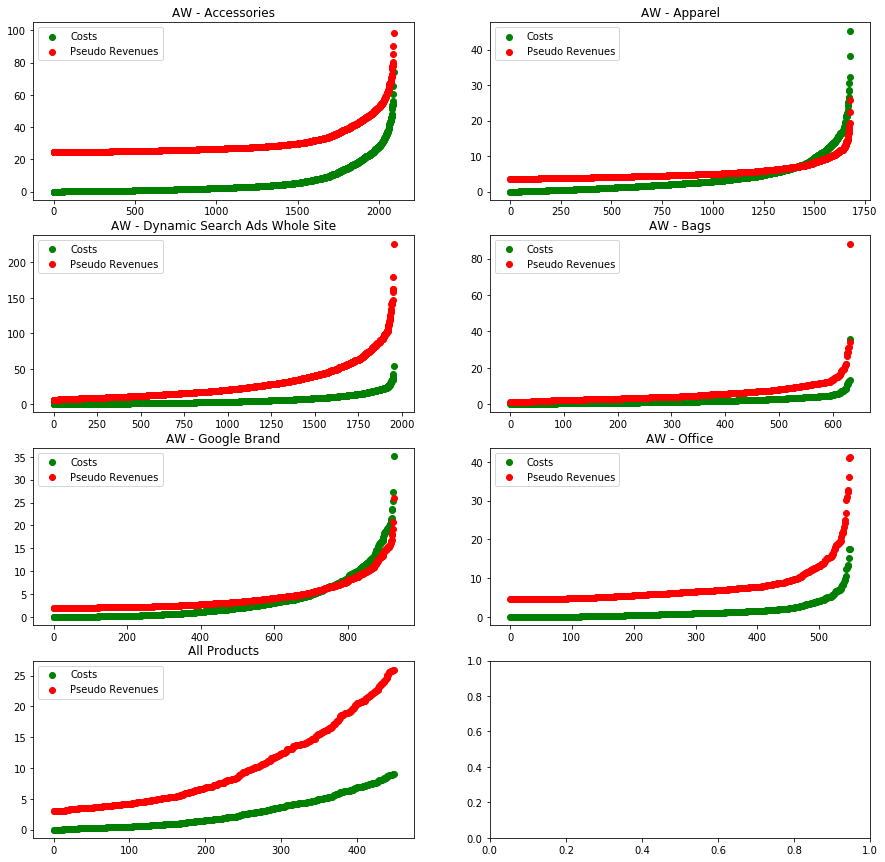

In [14]:
scatterRevenues(sumPredictedDf)

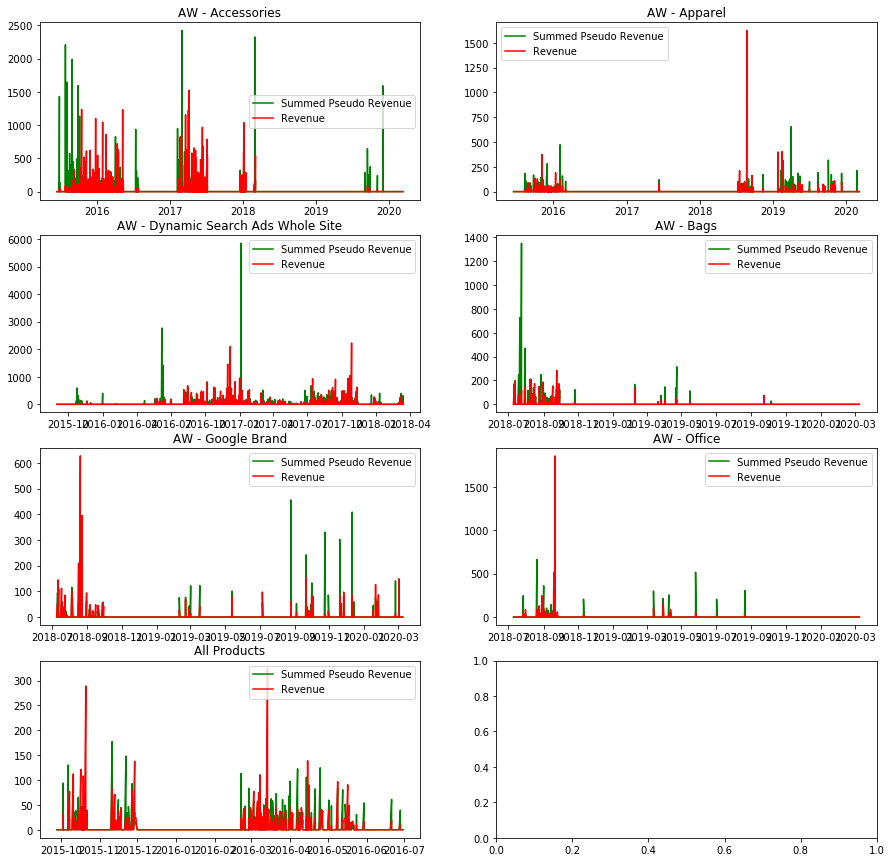

In [15]:
plotSummedRevenues(sumPredictedDf)

In [16]:
# from ipynb.fs.defs.nb3 import scatterSummedRevenues
# scatterSummedRevenues(sumPredictedDf)

In [17]:
# scatterErrorSummedRevenues(sumPredictedDf)

In [18]:
# plotFinalResults(sumPredictedDf, LROverallError)

In [19]:
LROverallError = getOverallError(sumPredictedDf)
display(LROverallError)

,Campaign,Sum Revenues,Sum Pseudo Revenues,Avg Revenue,Avg Diff Error (L1),Avg Relative (%)
0,AW - Accessories,63700.71,15899.863315,140.930774,166.868 +/- 307.444,54.213339
1,AW - Apparel,9104.17,741.893184,65.972246,72.957 +/- 156.020,52.513624
2,AW - Bags,3721.28,454.015363,71.563077,114.030 +/- 192.078,61.440870
3,AW - Dynamic Search Ads Whole Site,57540.27,16878.118913,150.628979,178.112 +/- 378.872,54.180056
4,AW - Google Brand,4122.77,298.597579,73.620893,79.307 +/- 115.429,51.859030
5,AW - Office,4269.28,363.718022,118.591111,162.742 +/- 324.408,57.846787
6,All Products,4502.51,1503.102495,41.307431,34.007 +/- 44.965,45.153495


# 2 Linear Regression with 1 extra feature

Add Device category to the list

In [20]:
trainDfTwoFeatures = pd.get_dummies(trainDf, columns=["Device Category"])

Stats = getMinMax(trainDfTwoFeatures)
features = ["Cost", "Device Category_desktop", "Device Category_mobile", "Device Category_tablet"]
models, errors = trainAllCampaignsLR(trainDfTwoFeatures, Stats, LinearRegression, features=features)
display(pd.DataFrame(errors.items(), columns=["Campaign", "Error (L1)"]))

predictedDf2F = createPseudoRevenues(models, trainDfTwoFeatures, Stats, features=features)
sumPredictedDf2F = createSumPredictedPseudoRevenue(predictedDf2F)

,Campaign,Error (L1)
0,AW - Accessories,37.511064
1,AW - Apparel,6.873972
2,AW - Dynamic Search Ads Whole Site,35.379945
3,AW - Bags,7.445541
4,AW - Google Brand,5.991571
5,AW - Office,11.109605
6,All Products,9.113277


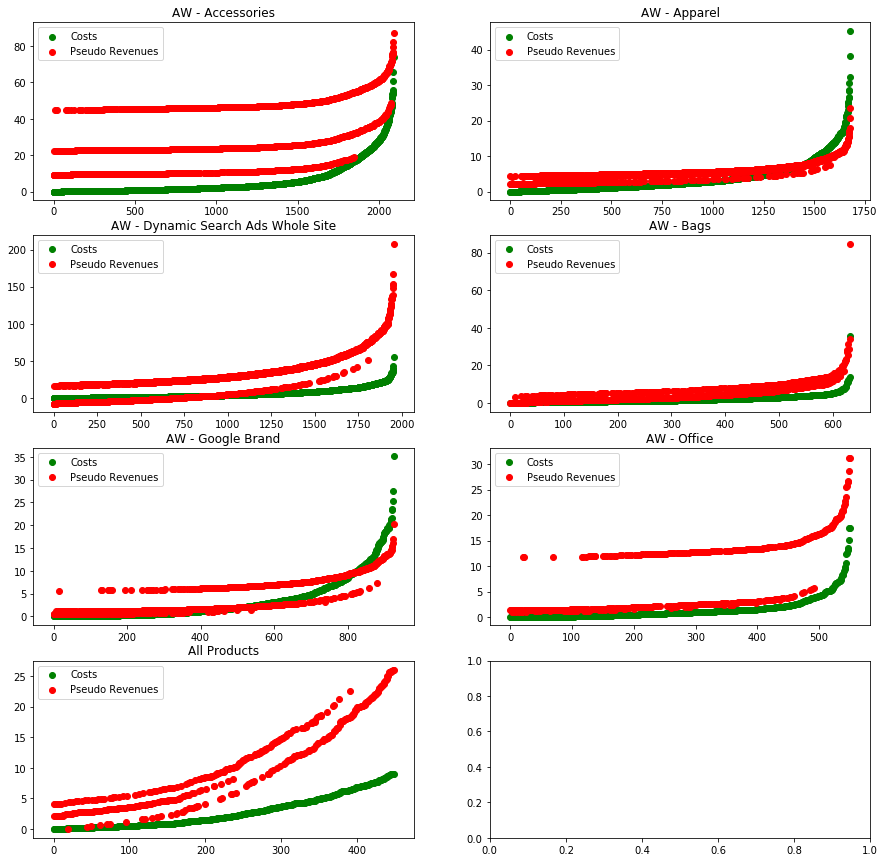

In [21]:
scatterRevenues(sumPredictedDf2F)

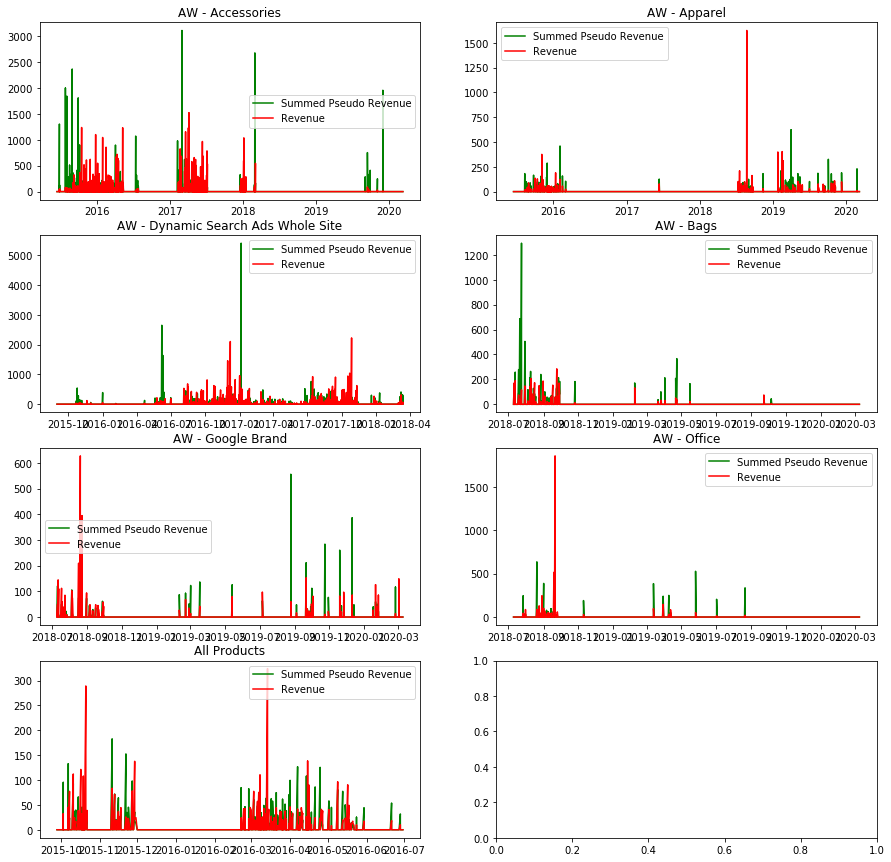

In [22]:
plotSummedRevenues(sumPredictedDf2F)

In [23]:
# scatterErrorSummedRevenues(sumPredictedDf2F)

In [24]:
display(getOverallError(sumPredictedDf2F))

,Campaign,Sum Revenues,Sum Pseudo Revenues,Avg Revenue,Avg Diff Error (L1),Avg Relative (%)
0,AW - Accessories,63700.71,19031.776091,140.930774,168.556 +/- 334.458,54.463060
1,AW - Apparel,9104.17,772.811533,65.972246,72.691 +/- 155.163,52.422604
2,AW - Bags,3721.28,467.224777,71.563077,121.272 +/- 186.602,62.889063
3,AW - Dynamic Search Ads Whole Site,57540.27,18141.063265,150.628979,176.420 +/- 363.601,53.942928
4,AW - Google Brand,4122.77,303.268465,73.620893,78.401 +/- 117.738,51.572141
5,AW - Office,4269.28,360.544758,118.591111,164.995 +/- 324.396,58.181562
6,All Products,4502.51,1564.893879,41.307431,33.662 +/- 44.837,44.901083


# 3. Linear Regression with multiple features (TODO)

In [25]:
trainDfAllFeatures = pd.get_dummies(trainDf, columns=["Device Category"])
for col in trainDfAllFeatures:
    if col == "Bucket Index":
        continue
    try:
        trainDfAllFeatures[col] = trainDfAllFeatures[col].astype(np.float32)
    except Exception:
        pass
Stats = getMinMax(trainDfAllFeatures)

features = ["Cost", "Device Category_desktop", "Device Category_mobile", "Device Category_tablet", \
            "Users", "Sessions", "Bounces", "Transactions", "Product Detail Views", \
            "Product Adds To Cart", "Product Checkouts", "Total Unique Searches", \
            "New Users", "Session Duration (s)"]
models, errors = trainAllCampaignsLR(trainDfAllFeatures.reset_index(drop=True).copy(), Stats, LinearRegression, features=features)
display(pd.DataFrame(errors.items(), columns=["Campaign", "Error (L1)"]))

predictedDfAllF = createPseudoRevenues(models, trainDfAllFeatures, Stats, features=features)
sumPredictedDfAllF = createSumPredictedPseudoRevenue(predictedDfAllF)

,Campaign,Error (L1)
0,AW - Accessories,30.737461
1,AW - Apparel,6.907056
2,AW - Dynamic Search Ads Whole Site,33.166084
3,AW - Bags,7.539229
4,AW - Google Brand,7.634237
5,AW - Office,18.742382
6,All Products,8.615076


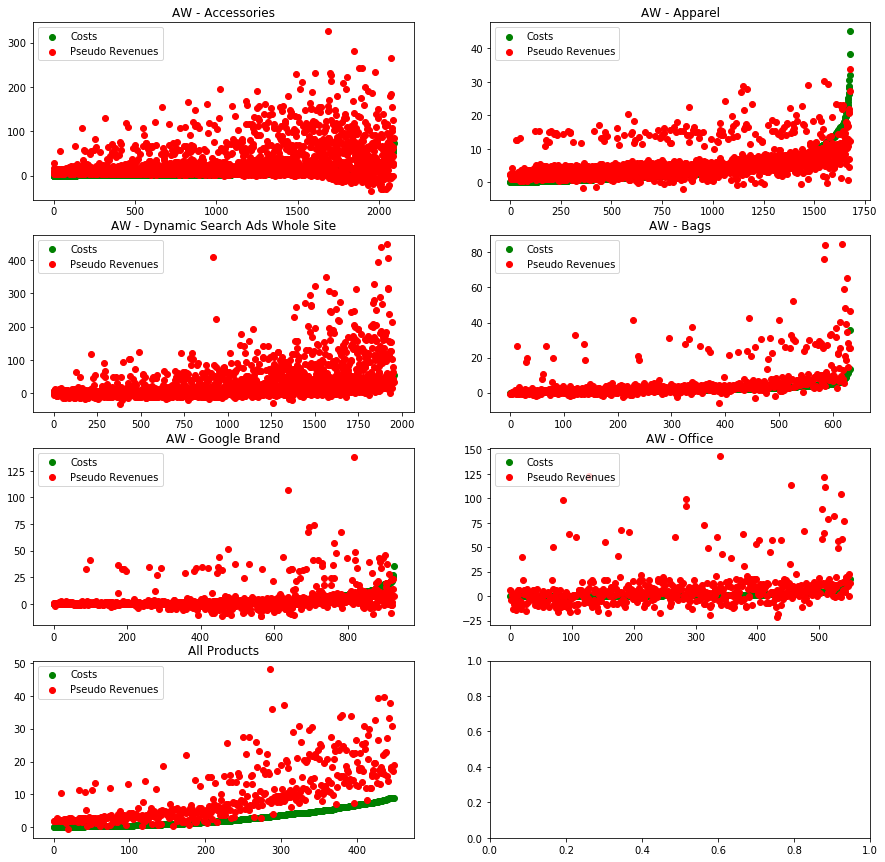

In [26]:
scatterRevenues(sumPredictedDfAllF)

In [27]:
display(getOverallError(sumPredictedDfAllF))

,Campaign,Sum Revenues,Sum Pseudo Revenues,Avg Revenue,Avg Diff Error (L1),Avg Relative (%)
0,AW - Accessories,63700.710938,41835.269531,140.930771,118.545 +/- 181.164,45.686276
1,AW - Apparel,9104.169922,2212.122070,65.972244,65.087 +/- 150.329,49.662082
2,AW - Bags,3721.279785,1693.775146,71.563072,88.165 +/- 62.109,55.197055
3,AW - Dynamic Search Ads Whole Site,57540.269531,42590.789062,150.628983,159.558 +/- 219.051,51.439289
4,AW - Google Brand,4122.769531,2268.573242,73.620888,55.668 +/- 84.696,43.057098
5,AW - Office,4269.279785,2631.226807,118.591103,132.337 +/- 295.425,52.739037
6,All Products,4502.509766,2371.624268,41.307430,28.301 +/- 41.194,40.657180
